In [14]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from TOV_Solver import WaveNetTOV, evaluate_model
import matplotlib.pyplot as plt
import joblib
from TOV_Solver import tov_load_and_preprocess
from preprocessing import _resample_group


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Train Loss: 0.000186 | Val Loss: 0.000187 | Val R²: 0.997314 | LR: 1.000000e-05
ckpt = torch.load("models/tov_solver.pt", map_location="cpu")

# 3️⃣ If it’s a dict:
model = WaveNetTOV()
model.load_state_dict(ckpt)
model.eval()

WaveNetTOV(
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
  (input_conv): CausalConv1d(
    (conv): Conv1d(1, 16, kernel_size=(2,), stride=(1,))
  )
  (hidden_layers): ModuleList(
    (0): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
    )
    (1): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
    )
    (2): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
    )
    (3): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(8,))
    )
    (4): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(16,))
    )
    (5): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(32,))
    )
    (6): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(16,))
    )
    (7): CausalConv1d(
      (conv): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(8,))
    )

Input Data

In [17]:
df = pd.read_csv("data/sample_mr.csv")

# pick one ID/model pair
group = df[(df["ID"] == df["ID"].iloc[0]) & (df["model"] == df["model"].iloc[0])]

out = _resample_group(group, column="M", Np=32)
print(out)

         ID model          R         M
0   19914.0   DDB  15.281294  0.202767
1   19914.0   DDB  14.049282  0.236253
2   19914.0   DDB  12.841903  0.324063
3   19914.0   DDB  12.545521  0.379058
4   19914.0   DDB  12.195752  0.511737
5   19914.0   DDB  12.171155  0.588827
6   19914.0   DDB  12.176193  0.761205
7   19914.0   DDB  12.192516  0.854382
8   19914.0   DDB  12.284489  1.048114
9   19914.0   DDB  12.339509  1.145830
10  19914.0   DDB  12.377969  1.336132
11  19914.0   DDB  12.401378  1.426367
12  19914.0   DDB  12.394830  1.512068
13  19914.0   DDB  12.350271  1.667311
14  19914.0   DDB  12.324575  1.736070
15  19914.0   DDB  12.221141  1.855174
16  19914.0   DDB  12.156521  1.905641
17  19914.0   DDB  12.009574  1.989401
18  19914.0   DDB  11.928549  2.023263
19  19914.0   DDB  11.754639  2.076594
20  19914.0   DDB  11.669556  2.096751
21  19914.0   DDB  11.575342  2.113021
22  19914.0   DDB  11.382532  2.135192
23  19914.0   DDB  11.284625  2.141697
24  19914.0   DDB  11.088

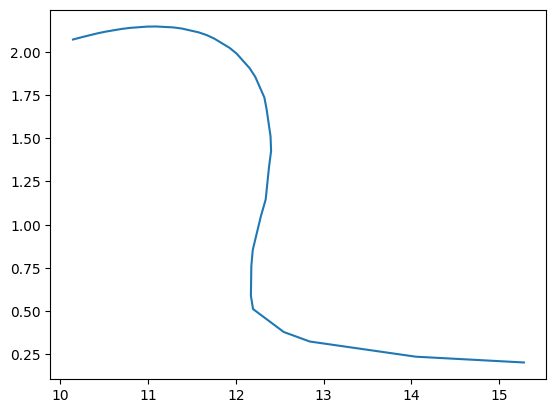

In [18]:
R = out["R"].to_numpy()
M = out["M"].to_numpy()

plt.plot(R, M)
plt.show()

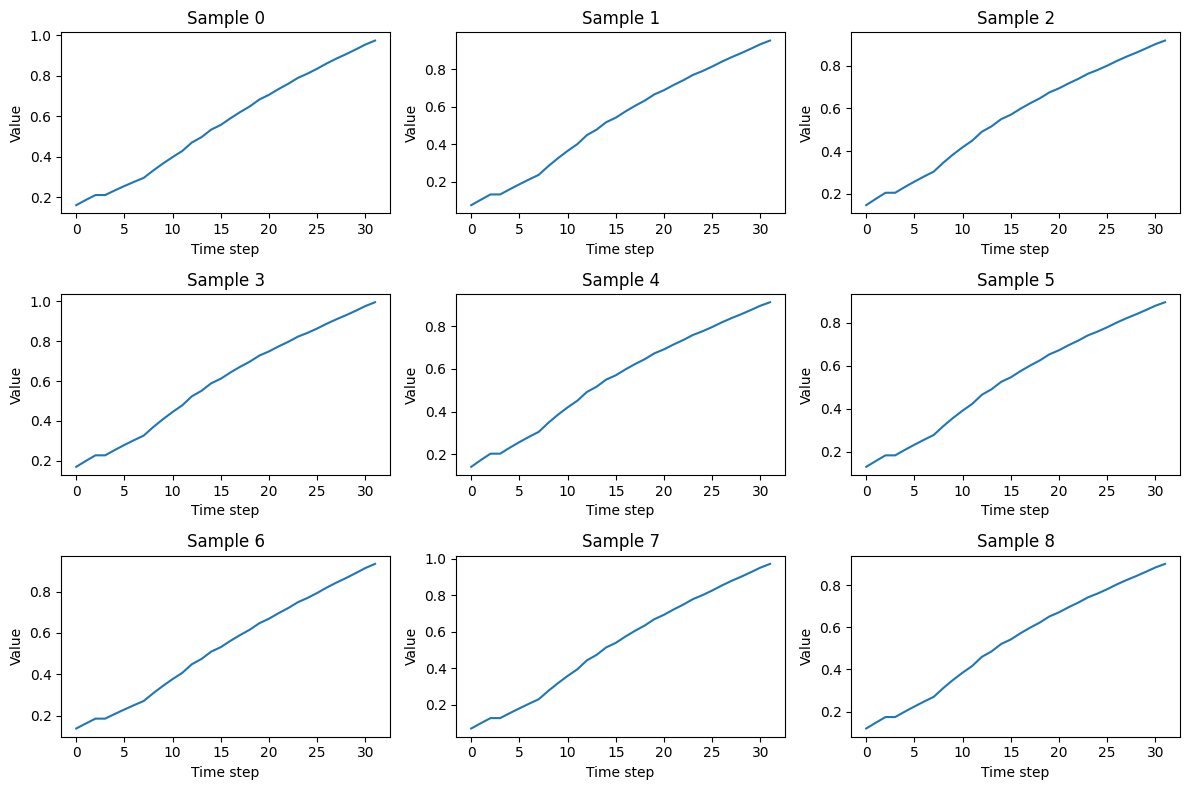

In [19]:
X_scaled = np.load("data/X_scaled.npy")
X_scaled.shape

# Plot first few samples
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(9):
    axes[i].plot(X_scaled[i, :, 0])  # Extract the feature dimension
    axes[i].set_title(f'Sample {i}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Value')
    
plt.tight_layout()

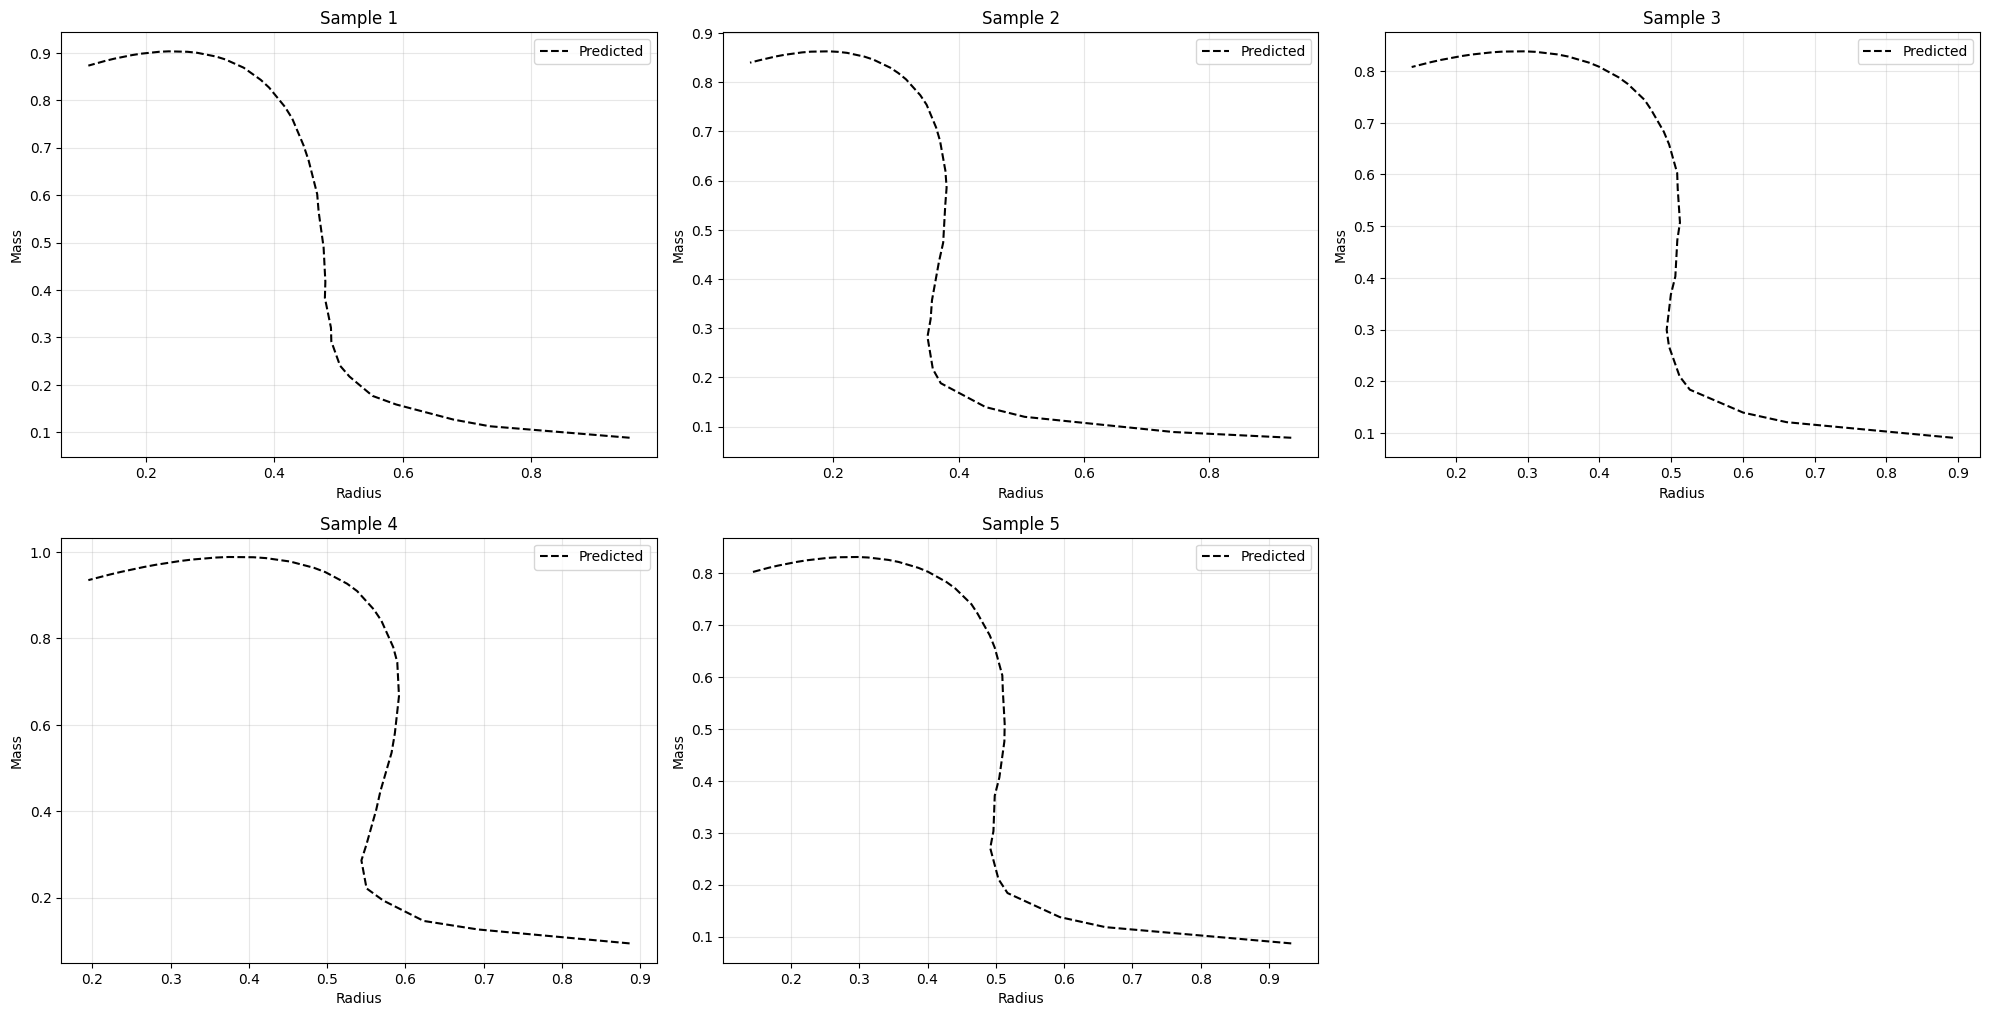

In [20]:
Y_scaled = np.load("data/Y_scaled.npy")

mass_pred_unscaled = Y_scaled[:, :, 0] 
radius_pred_unscaled = Y_scaled[:, :, 1] 

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for sample_idx in range(5):
    ax = axes[sample_idx]

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='black', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(5, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Results

In [21]:
np.load("data/y_test.npy").shape

(6000, 32, 2)

In [22]:
metrics, preds = evaluate_model(model, np.load("data/X_test.npy"), np.load("data/y_test.npy"))
metrics

{'MSE': 0.0001839596952777356, 'R2': 0.9973582029342651}

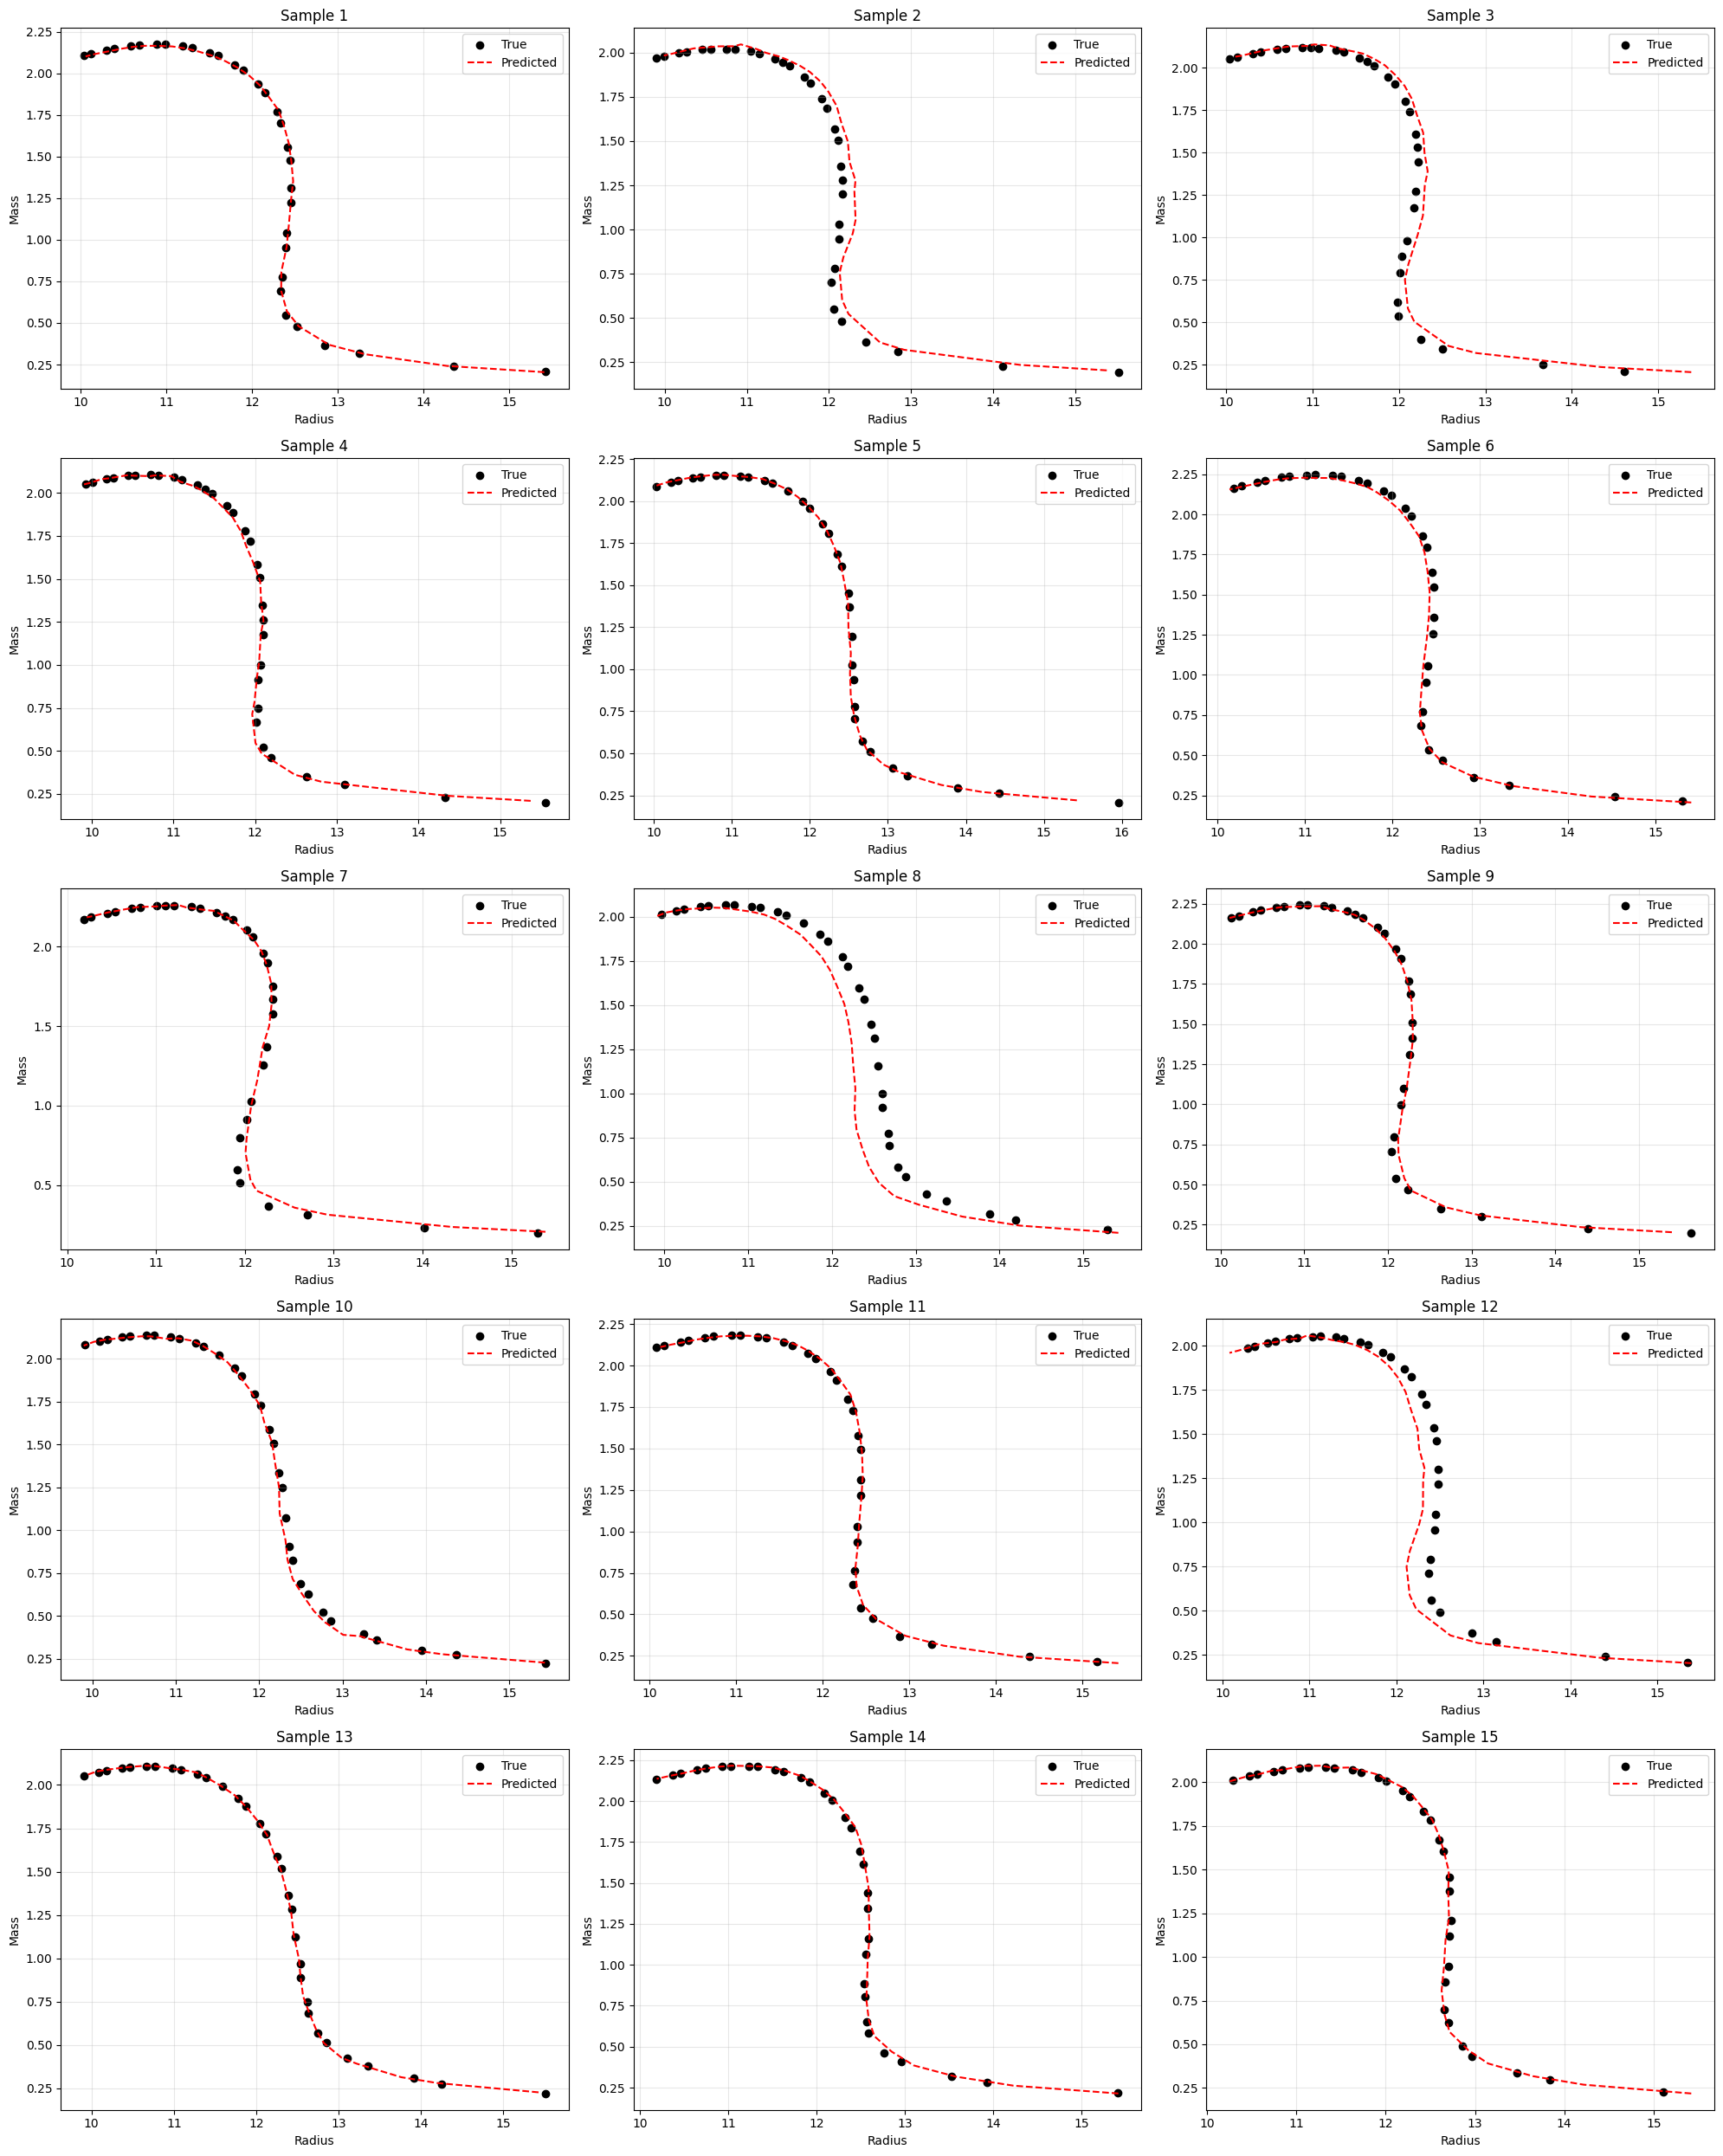

In [24]:
observed_mr = pd.read_csv("data/sample_mr.csv")
M_MAX = observed_mr.query("ID != 19248")["M"].max()
R_MAX = 16.0
R_MIN = observed_mr.query("ID != 19248")["R"].min()

y_test = np.load("data/y_test.npy")
mass_pred_unscaled = preds[:, :, 0] * M_MAX
radius_pred_unscaled = preds[:, :, 1] * (R_MAX - R_MIN) + R_MIN
# Inverse-transform true values
mass_true_unscaled = y_test[:, :, 0] * M_MAX
radius_true_unscaled = y_test[:, :, 1] * (R_MAX - R_MIN) + R_MIN

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for sample_idx in range(15):
    ax = axes[sample_idx]

    # True M-R relation (black)
    ax.scatter(radius_true_unscaled[sample_idx], mass_true_unscaled[sample_idx],
               color='black', label='True')

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='red', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(15, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [25]:
preds[0]

array([[0.08456416, 0.9102563 ],
       [0.09995162, 0.7385412 ],
       [0.12892199, 0.5936938 ],
       [0.15243359, 0.52931976],
       [0.19858843, 0.47544235],
       [0.23576194, 0.45452967],
       [0.28674844, 0.4443481 ],
       [0.3340908 , 0.44467604],
       [0.3953856 , 0.45397052],
       [0.4482556 , 0.45778435],
       [0.51282483, 0.4618894 ],
       [0.5594004 , 0.46558145],
       [0.60801405, 0.46242633],
       [0.6542539 , 0.45773214],
       [0.6962204 , 0.4494096 ],
       [0.7359467 , 0.43954632],
       [0.76865476, 0.42241523],
       [0.7963186 , 0.4075479 ],
       [0.8214734 , 0.3879094 ],
       [0.8407917 , 0.36799422],
       [0.85678625, 0.34671432],
       [0.86977947, 0.32567912],
       [0.8808228 , 0.29976568],
       [0.8888644 , 0.27716795],
       [0.8941809 , 0.25162476],
       [0.8955043 , 0.23087503],
       [0.89581925, 0.20430784],
       [0.89337116, 0.1835101 ],
       [0.88818586, 0.16011155],
       [0.8820948 , 0.1392511 ],
       [0.

In [27]:
y_test[0]

array([[0.08632062, 0.9122251 ],
       [0.09893816, 0.74996305],
       [0.13088675, 0.5820101 ],
       [0.15053464, 0.5221228 ],
       [0.19765307, 0.47204563],
       [0.22511724, 0.4518751 ],
       [0.2871325 , 0.44275546],
       [0.32114398, 0.44642726],
       [0.39328134, 0.45310378],
       [0.43051952, 0.45457685],
       [0.505102  , 0.46110883],
       [0.5416256 , 0.46088374],
       [0.61143214, 0.4598368 ],
       [0.6441756 , 0.45549372],
       [0.70432633, 0.44305396],
       [0.73144203, 0.43637213],
       [0.7792737 , 0.41555306],
       [0.7998942 , 0.40350258],
       [0.83454823, 0.37685278],
       [0.8486749 , 0.36251932],
       [0.8709549 , 0.33336657],
       [0.87933695, 0.3177639 ],
       [0.8912337 , 0.28615624],
       [0.89501905, 0.27032527],
       [0.89891815, 0.2388314 ],
       [0.89927536, 0.22333258],
       [0.8973511 , 0.19293875],
       [0.8952615 , 0.17808942],
       [0.8892438 , 0.14921716],
       [0.8854575 , 0.13521399],
       [0.